<a href="https://colab.research.google.com/github/srvmishra/Language-Models/blob/main/BERT_Base_Uncased_Finetuning_on_GLUE_MRPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import markdown
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel, TrainingArguments, Trainer
from datasets import load_dataset
from huggingface_hub import notebook_login

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Download Data and Visualize

In [3]:
mrpc_data = load_dataset('glue', 'mrpc')

print('Original Columns ', mrpc_data['train'].column_names)
print('Features ', mrpc_data['train'].features)

mrpc_data = mrpc_data.rename_column('label', 'labels')

print('New Columns ', mrpc_data['train'].column_names)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Original Columns  ['sentence1', 'sentence2', 'label', 'idx']
Features  {'sentence1': Value(dtype='string', id=None), 'sentence2': Value(dtype='string', id=None), 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None), 'idx': Value(dtype='int32', id=None)}
New Columns  ['sentence1', 'sentence2', 'labels', 'idx']


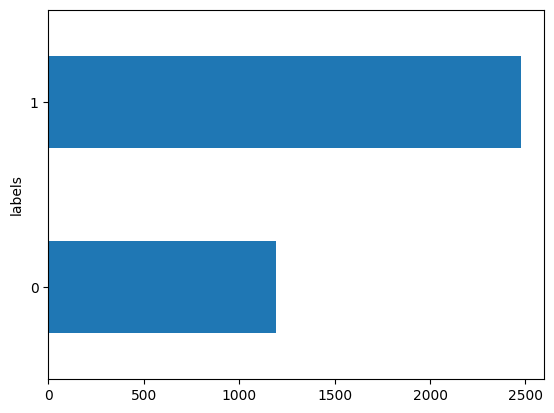

In [4]:
mrpc_data.set_format('pandas')
df = mrpc_data['train'][:]
df.value_counts('labels', ascending=True).plot.barh()
plt.show()
mrpc_data.reset_format()

### Download Models and Tokenizers

In [5]:
model_ckpt = 'bert-base-uncased'
feature_model = AutoModel.from_pretrained(model_ckpt).to(device)
classifier_model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenize Datasets

In [6]:
def batch_tokenize_both(batch):
    return tokenizer(batch['sentence1'], batch['sentence2'], truncation=True)

def batch_tokenize_single(batch):
    outputs_1 = tokenizer(batch['sentence1'], truncation=True)
    outputs_2 = tokenizer(batch['sentence2'], truncation=True)
    return {'input_ids_1': outputs_1.input_ids,
            'attention_mask_1': outputs_1.attention_mask,
            'token_type_ids_1': outputs_1.token_type_ids,
            'input_ids_2': outputs_2.input_ids,
            'attention_mask_2': outputs_2.attention_mask,
            'token_type_ids_2': outputs_2.token_type_ids}

# def batch_labels_map(batch):
#     return {'label_ids': mrpc_data['train'].features['labels']}

In [7]:
mrpc_data_tokenized_both = mrpc_data.map(batch_tokenize_both, batched=True)
mrpc_data_tokenized_single = mrpc_data.map(batch_tokenize_single, batched=True)

print('New Columns Single ', mrpc_data_tokenized_single['train'].column_names)
print('New Columns Both ', mrpc_data_tokenized_both['train'].column_names)

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

New Columns Single  ['sentence1', 'sentence2', 'labels', 'idx', 'input_ids_1', 'attention_mask_1', 'token_type_ids_1', 'input_ids_2', 'attention_mask_2', 'token_type_ids_2']
New Columns Both  ['sentence1', 'sentence2', 'labels', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']


### Finetune BERT

In [8]:
def compute_metrics(predictions):
    preds = predictions.predictions.argmax(-1)
    labels = predictions.label_ids
    return {'acc': accuracy_score(labels, preds),
            'f1': f1_score(labels, preds)}

In [9]:
batch_size = 64
logging_steps = len(mrpc_data_tokenized_both['train'])//64
model_name = f'srvmishra832/glue-mrpc-{model_ckpt}'
notebook_login()
training_args = TrainingArguments(output_dir=model_name, num_train_epochs=5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy='epoch', push_to_hub=True,
                                  disable_tqdm=False, logging_steps=logging_steps, log_level='error')
trainer = Trainer(model=classifier_model, args=training_args, compute_metrics=compute_metrics,
                  train_dataset=mrpc_data_tokenized_both['train'],
                  eval_dataset=mrpc_data_tokenized_both['test'],
                  tokenizer=tokenizer)
trainer.train()
trainer.push_to_hub()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-a28746d8405b>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=classifier_model, args=training_args, compute_metrics=compute_metrics,
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: srvmishra832 (srvmishra832-indian-institute-of-science-bangalore) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acc,F1
1,0.578100,0.520152,0.750725,0.806655
2,0.378200,0.470248,0.800000,0.860606
3,0.197300,0.473076,0.819130,0.865864
4,0.101300,0.676392,0.814493,0.866221
5,0.054400,0.730781,0.818551,0.869529


events.out.tfevents.1741627073.8e7b44f9e33b.1863.0:   0%|          | 0.00/8.32k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/srvmishra832/glue-mrpc-bert-base-uncased/commit/83422f154b3244d7f3b68894913c58308cfa620c', commit_message='End of training', commit_description='', oid='83422f154b3244d7f3b68894913c58308cfa620c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/srvmishra832/glue-mrpc-bert-base-uncased', endpoint='https://huggingface.co', repo_type='model', repo_id='srvmishra832/glue-mrpc-bert-base-uncased'), pr_revision=None, pr_num=None)

In [10]:
test_predictions = trainer.predict(mrpc_data_tokenized_both['test'])
print(test_predictions.metrics)
acc = accuracy_score(mrpc_data_tokenized_both['test']['labels'], test_predictions.predictions.argmax(-1))
f1 = f1_score(mrpc_data_tokenized_both['test']['labels'], test_predictions.predictions.argmax(-1))
print('Finetuned BERT Model: accuracy: {:.2f}, f1: {:.2f}'.format(acc, f1))

{'test_loss': 0.730780839920044, 'test_acc': 0.8185507246376812, 'test_f1': 0.8695289704043352, 'test_runtime': 7.5561, 'test_samples_per_second': 228.292, 'test_steps_per_second': 3.573}
Finetuned BERT Model: accuracy: 0.82, f1: 0.87


### Extract Features from Data for Classifiers in the next parts

In [11]:
def extract_double_features(batch):
  batch = {k: v.unsqueeze(0).to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = feature_model(**batch).last_hidden_state[:, 0]
  return {'double features': output.cpu().numpy()}

def extract_single_features(batch):
  cols_1 = ['input_ids_1', 'token_type_ids_1', 'attention_mask_1']
  cols_2 = ['input_ids_2', 'token_type_ids_2', 'attention_mask_2']

  batch_1 = {k.split('_1')[0]: v.unsqueeze(0).to(device) for k, v in batch.items() if k in cols_1}
  batch_2 = {k.split('_2')[0]: v.unsqueeze(0).to(device) for k, v in batch.items() if k in cols_2}

  with torch.no_grad():
    output_1 = feature_model(**batch_1).last_hidden_state[:, 0]
    output_2 = feature_model(**batch_2).last_hidden_state[:, 0]

  return {'feature 1': output_1.cpu().numpy(), 'feature 2': output_2.cpu().numpy()}

In [12]:
mrpc_data_tokenized_both.set_format('torch', columns=tokenizer.model_input_names+['labels'])
mrpc_data_tokenized_both_with_features = mrpc_data_tokenized_both.map(extract_double_features,
                                                                      batched=False)

mrpc_data_tokenized_single.set_format('torch', columns=['input_ids_1', 'token_type_ids_1', \
                                                        'attention_mask_1', 'input_ids_2', \
                                                        'token_type_ids_2', 'attention_mask_2',
                                                        'labels'])
mrpc_data_tokenized_single_with_features = mrpc_data_tokenized_single.map(extract_single_features,
                                                                          batched=False)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

### Classifiers from sklearn - Logistic Regression, SVM, Random Forest

In [13]:
print('New Columns Both ', mrpc_data_tokenized_both_with_features['train'].column_names)
print('New Columns Single ', mrpc_data_tokenized_single_with_features['train'].column_names)

mrpc_data_tokenized_both_with_features.set_format('numpy', columns=['double features', 'labels'])
mrpc_data_tokenized_single_with_features.set_format('numpy', columns=['feature 1', 'feature 2',
                                                                      'labels'])

New Columns Both  ['sentence1', 'sentence2', 'labels', 'idx', 'input_ids', 'token_type_ids', 'attention_mask', 'double features']
New Columns Single  ['sentence1', 'sentence2', 'labels', 'idx', 'input_ids_1', 'attention_mask_1', 'token_type_ids_1', 'input_ids_2', 'attention_mask_2', 'token_type_ids_2', 'feature 1', 'feature 2']


In [14]:
Xtrain = mrpc_data_tokenized_both_with_features['train']['double features'].squeeze(1)
Xtest = mrpc_data_tokenized_both_with_features['test']['double features'].squeeze(1)
ytrain = mrpc_data_tokenized_both_with_features['train']['labels']
ytest = mrpc_data_tokenized_both_with_features['test']['labels']

In [15]:
def plot_conf_matrix(ax, predictions, targets, labels, title):
    cm = confusion_matrix(targets, predictions, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    ax.set_title('Normalized CM: {}'.format(title))
    return

In [16]:
lr = LogisticRegression(max_iter=1000)
sv = SVC(max_iter=1000)
rf = RandomForestClassifier(n_estimators=10)

lr.fit(Xtrain, ytrain)
sv.fit(Xtrain, ytrain)
rf.fit(Xtrain, ytrain)

lr_predictions = lr.predict(Xtest)
sv_predictions = sv.predict(Xtest)
rf_predictions = rf.predict(Xtest)

print('Logistic Regression: accuracy: {:.2f}, f1 score {:.2f}'.format(accuracy_score(ytest, lr_predictions),
                                                                      f1_score(ytest, lr_predictions)))
print('SVM: accuracy: {:.2f}, f1 score {:.2f}'.format(accuracy_score(ytest, sv_predictions),
                                                                      f1_score(ytest, sv_predictions)))
print('Random Forest: accuracy: {:.2f}, f1 score {:.2f}'.format(accuracy_score(ytest, rf_predictions),
                                                                      f1_score(ytest, rf_predictions)))

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Logistic Regression: accuracy: 0.72, f1 score 0.80
SVM: accuracy: 0.71, f1 score 0.81
Random Forest: accuracy: 0.66, f1 score 0.75


In [17]:
predictions = [lr_predictions, sv_predictions, rf_predictions,
               test_predictions.predictions.argmax(-1)]
labels = mrpc_data['train'].features['labels'].names
titles = ['Logistic Regression', 'SVM', 'Random Forest', 'Finetuned BERT']

### PyTorch Neural Network

In [18]:
class NeuralNetwork(nn.Module):
  def __init__(self, num_inputs, num_outputs=1):
    super(NeuralNetwork, self).__init__()
    self.model = nn.Sequential(nn.Linear(num_inputs, 4*num_inputs),
                               nn.ReLU(),
                               nn.Linear(4*num_inputs, num_outputs))
  def forward(self, x):
    return self.model(x)

class BERTDataset(Dataset):
  def __init__(self, x, y):
    self.data = torch.from_numpy(x)
    self.targets = torch.from_numpy(y)

  def __getitem__(self, index):
    return self.data[index], self.targets[index]

  def __len__(self):
    return len(self.data)

def train(model, optimizer, train_dataloader, test_dataloader, criterion, epochs=10):
  model.to(device)
  model.train()

  for i in tqdm(range(epochs)):
    for batch in train_dataloader:
      x, y = batch
      x, y = x.to(device), y.to(device).unsqueeze(1).float()
      yhat = model(x)
      loss = criterion(yhat, y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

  model.eval()
  preds, targets = [], []
  with torch.no_grad():
    for batch in test_dataloader:
      x, y = batch
      yhat = model(x.to(device))
      preds.append(yhat.argmax(-1).cpu().numpy())
      targets.append(y.cpu().numpy())
  preds = np.hstack(preds)
  targets = np.hstack(targets)

  print(preds.shape, targets.shape)
  acc = accuracy_score(targets, preds)
  f1 = f1_score(targets, preds)
  print('PyTorch NN: accuracy score: {:.2f}, f1 score: {:.2f}'.format(acc, f1))
  return preds

In [19]:
model = NeuralNetwork(768)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = nn.BCEWithLogitsLoss()
train_dataloader = DataLoader(BERTDataset(Xtrain, ytrain),
                              shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(BERTDataset(Xtest, ytest),
                             shuffle=True, batch_size=batch_size)
nn_preds = train(model, optimizer, train_dataloader, test_dataloader, criterion)
predictions.append(nn_preds)
titles.append('PyTorch NN')

100%|██████████| 10/10 [00:01<00:00,  8.57it/s]

(1725,) (1725,)
PyTorch NN: accuracy score: 0.34, f1 score: 0.00


### Similarity between BERT features

In [20]:
def apply_cosine_sim(batch):
  sim = cosine_similarity(batch['feature 1'], batch['feature 2'])
  return {'similarity': sim.item()}

In [21]:
mrpc_data_tokenized_single_with_features = mrpc_data_tokenized_single_with_features.map(apply_cosine_sim, batched=False)
print('New Columns Single ', mrpc_data_tokenized_single_with_features['train'].column_names)


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

New Columns Single  ['sentence1', 'sentence2', 'labels', 'idx', 'input_ids_1', 'attention_mask_1', 'token_type_ids_1', 'input_ids_2', 'attention_mask_2', 'token_type_ids_2', 'feature 1', 'feature 2', 'similarity']


In [22]:
sims = mrpc_data_tokenized_single_with_features['train']['similarity']
targets = mrpc_data_tokenized_single_with_features['train']['labels']

ones = np.ones_like(targets)
zeros = np.zeros_like(targets)
f1_arr = []

for s in np.unique(sims):
  preds = np.where(sims < s, zeros, ones)
  f1_arr.append(f1_score(targets, preds))

f1 = np.array(f1_arr)
print('Best threshold on train set: {:.2f}'.format(np.unique(sims)[np.argmax(f1)]))
print('Best F1 score on the train set: {:.2f}'.format(np.max(f1)))

Best threshold on train set: 0.64
Best F1 score on the train set: 0.81


In [23]:
ytest = mrpc_data_tokenized_single_with_features['test']['labels']
sims = mrpc_data_tokenized_single_with_features['test']['similarity']
ones = np.ones_like(ytest)
zeros = np.zeros_like(ytest)
preds = np.where(sims < 0.64, zeros, ones)

acc = accuracy_score(ytest, preds)
f1 = f1_score(ytest, preds)
print('BERT similarity: accuracy: {:.2f}, f1: {:.2f}'.format(acc, f1))

predictions.append(preds)
titles.append('BERT cosine sim.')

BERT similarity: accuracy: 0.66, f1: 0.80


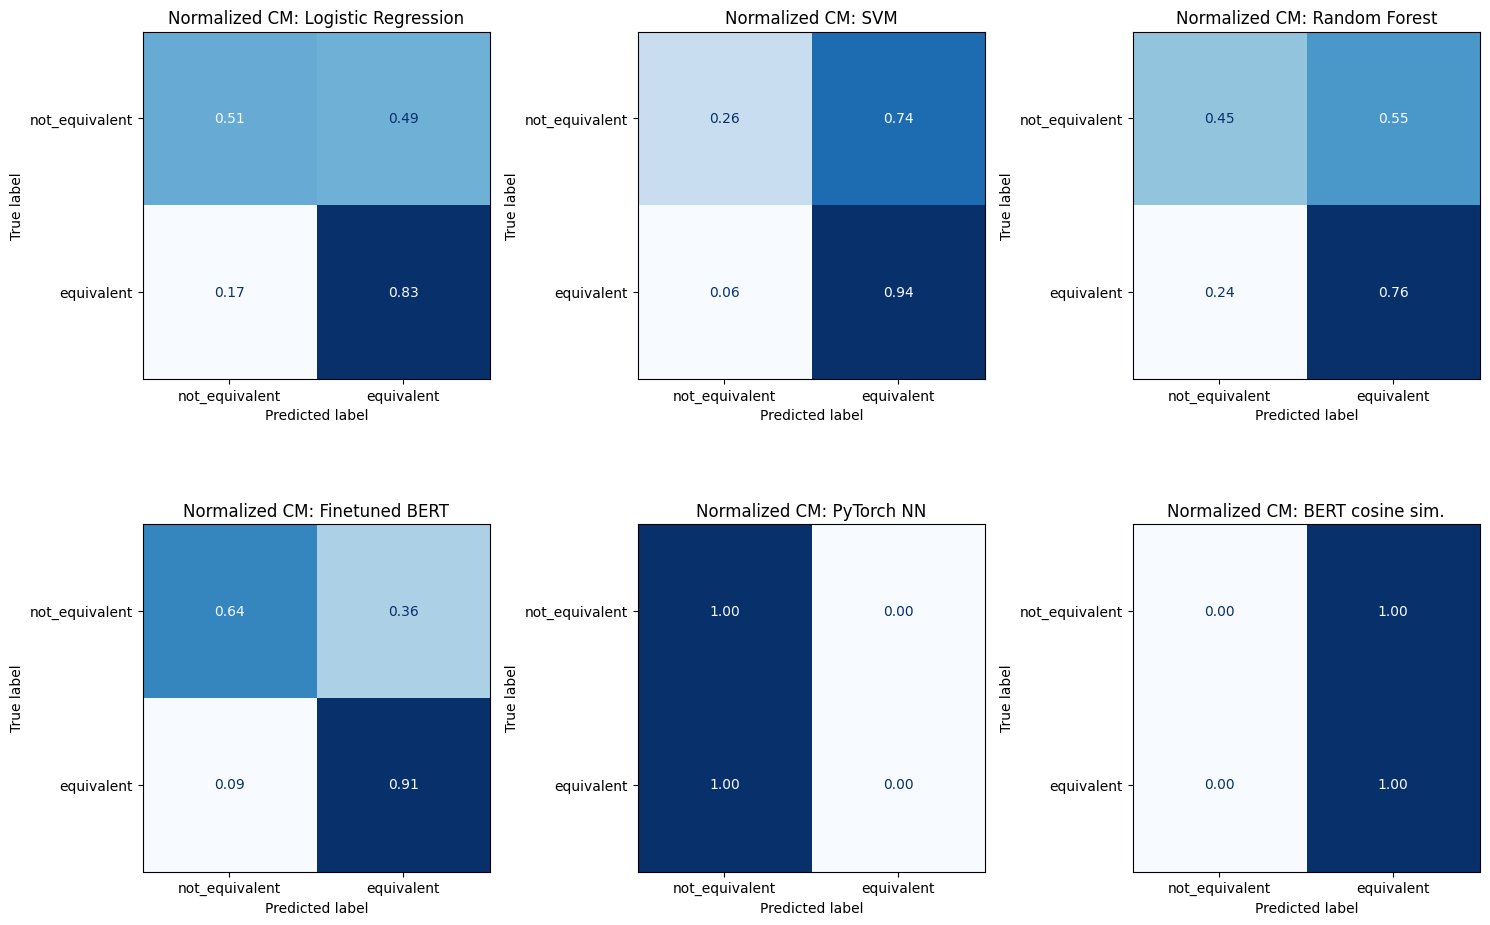

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axes = axs.flatten()

for ax, pred, title in zip(axes, predictions, titles):
  plot_conf_matrix(ax, pred, ytest, labels, title)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.show()